In [628]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import time

In [629]:
post_rate_val_a = 0.2
post_rate_val_b = 1.5

comment_rate_val = 0.2

new_group_creation_chance_a = 1
new_group_creation_chance_b = 20

existing_group_join_chance_a = 3
existing_group_join_chance_b = 5

niche_score_val_a = 1
niche_score_val_b = 3

thread_popularity_length = 5 # days the thread will remain at max popularity
thread_decay_rate = 0.2 # proportion of popularity lost per day after max popularity


In [630]:
class User:
    def __init__(self, acct_id):
        self.id = acct_id
        # The rate at which a post is made
        self.post_rate = stats.beta(post_rate_val_a, post_rate_val_b).rvs()
        # The rate at which a comment is made
        self.comment_rate = round(stats.expon(comment_rate_val).rvs())
        # The chance of making a new group at the creation time of the user
        self.new_group_creation_chance = stats.beta(
            new_group_creation_chance_a, new_group_creation_chance_b
        ).rvs()
        # The chance of joining any existing group at the time of creation of the user
        self.existing_group_join_chance = stats.beta(
            existing_group_join_chance_a, existing_group_join_chance_b
        ).rvs()
        # A score that increases the probability of commenting in smaller, more niche groups
        self.niche_score = stats.beta(niche_score_val_a, niche_score_val_b).rvs()
        self.groups = []
        self.posts = []
        self.comments = []


class Group:
    def __init__(self, group_id):
        self.id = group_id
        self.posts = []
        self.user_count = 0


class Post:
    def __init__(self, post_id, group_id, user):
        self.id = post_id
        self.group_id = group_id
        self.user = user
        self.age = 0
        self.comments = []
        # How active the post is - this can be useful for visualizations
        self.current_activity = 1
        self.highest_activity = 1


class Comment:
    def __init__(self, comment_id, post_id, parent_user_id, child_user_id):
        self.id = comment_id
        self.post_id = post_id
        self.parent_user_id = parent_user_id
        self.child_user_id = child_user_id


class Simulation:
    def __init__(self, num_users, num_groups, user_growth_rate, rounds):
        self.users = []
        self.groups = []
        self.posts = []
        self.comments = []
        self.user_growth_rate = user_growth_rate
        self.num_users = num_users
        self.num_groups = num_groups
        self.current_time = 0
        self.rounds = rounds
        self.interaction_matrix = dok_matrix(
            (
                num_users + user_growth_rate * rounds,
                num_users + user_growth_rate * rounds,
            ),
            dtype=np.int32,
        )
        self.initialize()

    def initialize(self):
        # create initial groups
        for i in range(self.num_groups):
            self.groups.append(Group(i))

        # create the users
        for i in range(self.num_users):
            self.add_user()

    def run(self):
        start_time = time.time()
        for i in range(self.rounds):
            if i % 10 == 0:
                print(i, end=" ")
            round_start_time = time.time()
            self.current_time += 1

            ## Make posts
            self.make_users_post()

            user_post_time = round(time.time() - round_start_time, 2)
            # print("post: ", user_post_time, end=" ")

            ## Make comments
            self.make_users_comment()

            user_comment_time = round(
                time.time() - user_post_time - round_start_time, 2
            )
            # print("comment: ", user_comment_time, end=" ")

            ## Update post age and activity
            self.update_posts()

            post_update_time = round(
                (time.time() - user_comment_time - user_post_time - round_start_time), 2
            )
            # print("update: ", post_update_time, end=" ")

            ## Make users join groups
            self.make_users_join()

            user_group_join_time = (
                time.time()
                - post_update_time
                - user_comment_time
                - user_post_time
                - round_start_time
            )
            # print("join: ", user_group_join_time, end=" ")

            total_round_time = time.time() - round_start_time
            # print("total: ", total_round_time, "\n")

            # add new users
            for i in range(self.user_growth_rate):
                self.add_user()

            # add new groups based on the user's new group creation chance
            for user in self.users[-self.user_growth_rate :]:
                if np.random.rand() < user.new_group_creation_chance:
                    self.groups.append(Group(len(self.groups)))
                    user.groups.append(self.groups[-1])
                    self.groups[-1].user_count += 1

        total_time = round(time.time() - start_time, 2)
        # print("total_time: ", total_time)

    def make_users_join(self):
        # the user joins groups weighted based on their current group's post activity
        # precompute group weight here
        group_weights = []
        for group in self.groups:
            group_activity = 0
            for post in group.posts:
                group_activity += post.current_activity
            group_weights.append(group_activity)
        group_weights = np.array(group_weights)
        group_weights = group_weights / np.sum(group_weights)

        for user in self.users:
            if np.random.rand() < user.existing_group_join_chance:
                group = self.groups[np.random.choice(len(self.groups), p=group_weights)]
                # check if user is already in group
                if group in user.groups:
                    continue
                user.groups.append(group)
                group.user_count += 1

    def make_users_comment(self):
        # find current activity for all groups
        group_activity = [
            sum([post.current_activity for post in group.posts])
            for group in self.groups
        ]
        group_activity = np.array(group_activity)
        group_activity = group_activity / np.sum(group_activity)

        # makes comments on posts based on post activity
        for user in self.users:
            # users will post user.comment_rate comments in groups that they are a part of
            # and post user.comment_rate comments in all groups

            # if user is only in one group we can skip all of the computationally expensive stuff below
            if len(user.groups) == 1:
                # check if the group has any posts
                if len(user.groups[0].posts) == 0:
                    continue
                rand_group = user.groups[0]
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])
                continue

            # if there is at least one group in the user's group that has more than 0 posts
            if len([group.id for group in user.groups if group.posts != []]) > 0:
                # Calculate group weights based on group size and niche score
                group_weights = [
                    (1 - (group.user_count / len(self.users))) * user.niche_score
                    for group in user.groups
                    if group.posts != []
                ]

                # Normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)

                rand_group_idxs = np.random.choice(
                    a=len([group.id for group in user.groups if group.posts != []]),
                    size=user.comment_rate,
                    p=group_weights,
                )

                for rand_group_idx in rand_group_idxs:
                    rand_group = user.groups[rand_group_idx]
                    if len(rand_group.posts) == 0:
                        continue
                    rand_post_idx = np.random.randint(len(rand_group.posts))
                    self.add_comment(user, rand_group.posts[rand_post_idx])

            # for all groups (still including the groups that the user is in)
            # Calculate group weights based on group size and niche score
            group_weights = [
                (1 - (group.user_count / len(self.users))) * user.niche_score
                for group in self.groups
            ]

            # Normalize the group weights
            group_weights = np.array(group_weights)
            group_weights = group_weights / np.sum(group_weights)

            rand_group_idxs = np.random.choice(
                a=len(self.groups), size=user.comment_rate, p=group_weights
            )

            for rand_group_idx in rand_group_idxs:
                rand_group = self.groups[rand_group_idx]
                if len(rand_group.posts) == 0:
                    continue
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])

    def make_users_post(self):
        # makes posts in groups based on groups size weighted by niche score
        for user in self.users:
            if np.random.rand() < user.post_rate:
                # normalized inverse group size weights
                group_weights = []
                for group in self.groups:
                    # normalize user count to range from 0 to 1
                    # values towards 0 (smaller groups) give a higher weight
                    normalized_user_count = 1 - (group.user_count / len(self.users))
                    group_weight = normalized_user_count * user.niche_score
                    group_weights.append(group_weight)

                # normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)
                # print("GROUP WEIGHTS:", group_weights)

                # weighted selection
                group = self.groups[np.random.choice(len(self.groups), p=group_weights)]
                post = self.add_post(user, group)

    def update_posts(self):
        for post in self.posts:
            post.age += 1
            if post.age <= thread_popularity_length:
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity
            else:
                post.current_activity *= 1 - (thread_decay_rate * (post.age - thread_popularity_length))
                if post.current_activity < 1:
                    post.current_activity = 1
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity

    def add_user(self):
        user = User(len(self.users))
        self.users.append(user)

        # check if user will create a new group
        if np.random.rand() < user.new_group_creation_chance:
            self.groups.append(Group(len(self.groups)))
            user.groups.append(self.groups[-1])
            self.groups[-1].user_count += 1

        # check if user will join any existing groups
        for group in self.groups:
            if np.random.rand() < user.existing_group_join_chance:
                # check if user is already in group
                if group in user.groups:
                    continue
                user.groups.append(group)
                group.user_count += 1
                
        # if user doesn't join any existing groups, join a random group
        if len(user.groups) == 0:
            rand_group = self.groups[np.random.randint(len(self.groups))]
            # check if user is already in group
            if rand_group in user.groups:
                return user
            user.groups.append(rand_group)
            rand_group.user_count += 1


    def add_group(self):
        group = Group(len(self.groups))
        self.groups.append(group)
        return group

    def add_post(self, user, group):
        post = Post(len(self.posts), group.id, user)
        user.posts.append(post)
        group.posts.append(post)
        self.posts.append(post)
        return post

    def add_comment(self, user, post):
        comment = Comment(len(self.comments), post.id, post.user.id, user.id)
        user.comments.append(comment)
        post.comments.append(comment)
        post.current_activity += 1
        if post.current_activity > post.highest_activity:
            post.highest_activity = post.current_activity
        self.interaction_matrix[user.id, post.user.id] += 1
        return comment

0 10 20 30 40 50 60 70 80 90 

Total users: 600
Total groups: 157
Mean interactions 0.42306666666666665
Mean interactions (between users with at least 1 interaction) 289.00189753320683
Max interactions 49
Most active user 100


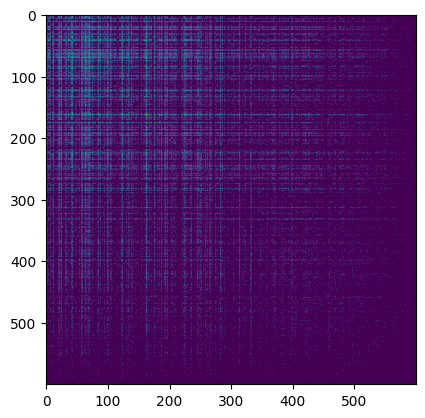

In [631]:
user_count = 100
group_count = 100
user_growth_rate = 5

sim = Simulation(user_count, group_count, user_growth_rate, rounds=100)

before_sim_user_group_counts = [len(user.groups) for user in sim.users]
before_sim_group_user_counts = [group.user_count for group in sim.groups]

# while True:
sim.run()
print("\n")

# since the interaction matrix ij only tracks the number of interactions from i to j and not j to i we sum the matrix with its transpose
sim.interaction_matrix = sim.interaction_matrix + sim.interaction_matrix.transpose()

# plot interaction matrix
print("Total users:", len(sim.users))
print("Total groups:", len(sim.groups))
print("Mean interactions", np.mean(sim.interaction_matrix.toarray()))
# finding mean interactions of users who have made at least one interaction
user_interaction_counts = np.sum(sim.interaction_matrix.toarray(), axis=1)
user_interaction_counts = user_interaction_counts[user_interaction_counts > 0]
print("Mean interactions (between users with at least 1 interaction)", np.mean(user_interaction_counts))
print("Max interactions", np.max(sim.interaction_matrix.toarray()))
most_active_user = np.argmax(np.sum(sim.interaction_matrix.toarray(), axis=1))
print("Most active user", most_active_user)
plt.imshow(np.log(sim.interaction_matrix.toarray() + 1))
plt.show()

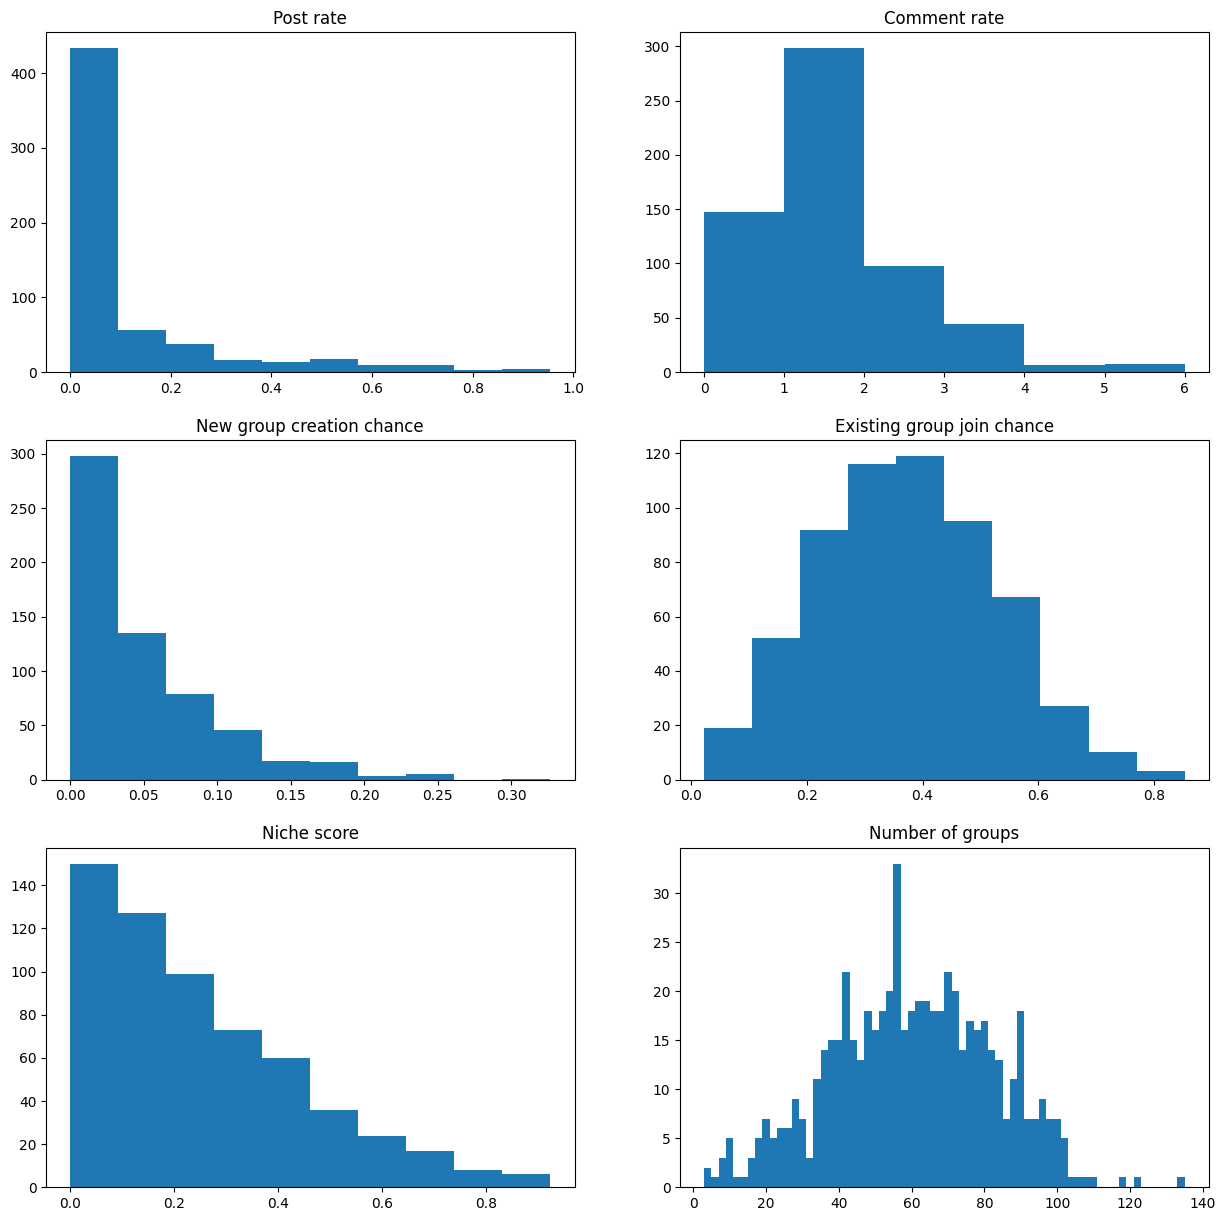

In [638]:
# subplot for each user attribute
# find how many users had psot rate of 0
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist([user.post_rate for user in sim.users], bins=10)
axs[0, 0].set_title("Post rate")
# find range of comment_rate s owe can set proper bins
comment_rate_min = min([user.comment_rate for user in sim.users])
comment_rate_max = max([user.comment_rate for user in sim.users])
comment_rate_range = comment_rate_max - comment_rate_min
axs[0, 1].hist([user.comment_rate for user in sim.users], bins=comment_rate_range)
axs[0, 1].set_title("Comment rate")
axs[1, 0].hist([user.new_group_creation_chance for user in sim.users], bins=10)
axs[1, 0].set_title("New group creation chance")
axs[1, 1].hist([user.existing_group_join_chance for user in sim.users], bins=10)
axs[1, 1].set_title("Existing group join chance")
axs[2, 0].hist([user.niche_score for user in sim.users], bins=10)
axs[2, 0].set_title("Niche score")
groups_min = min([len(user.groups) for user in sim.users])
groups_max = max([len(user.groups) for user in sim.users])
axs[2, 1].hist([len(user.groups) for user in sim.users], bins=round((groups_max - groups_min) / 2))
axs[2, 1].set_title("Number of groups")
plt.show()


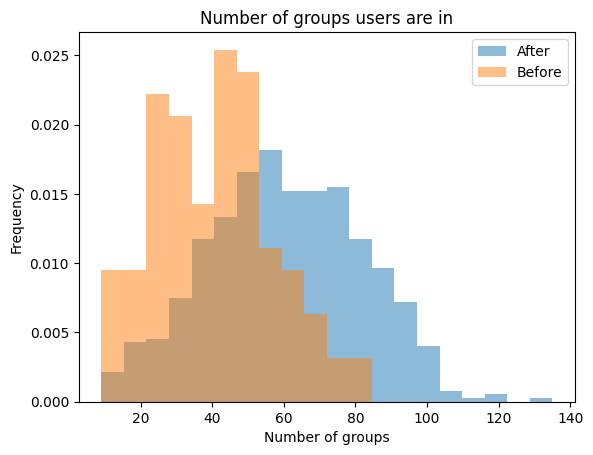

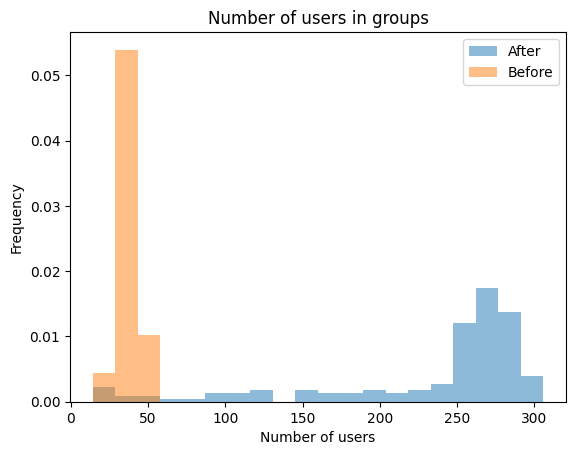

In [633]:
# getting min and max value from after simulation
user_groups_min = min(before_sim_user_group_counts)
user_groups_max = max([len(user.groups) for user in sim.users])
# for each user plot the number of groups they are in
plt.hist(
    [len(user.groups) for user in sim.users],
    label="After",
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=20,
    density=True,
)
plt.hist(
    before_sim_user_group_counts,
    label="Before",
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=20,
    density=True,
)
plt.title("Number of groups users are in")
plt.xlabel("Number of groups")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# getting min and max value from after simulation
group_user_counts_min = min(before_sim_group_user_counts)
group_user_counts_max = max([group.user_count for group in sim.groups])
# for each group plot the number of users in the group
plt.hist(
    [group.user_count for group in sim.groups],
    label="After",
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=20,
    density=True,
)
plt.hist(
    before_sim_group_user_counts,
    label="Before",
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=20,
    density=True,
)
plt.title("Number of users in groups")
plt.xlabel("Number of users")
plt.ylabel("Frequency")
plt.legend()
plt.show()

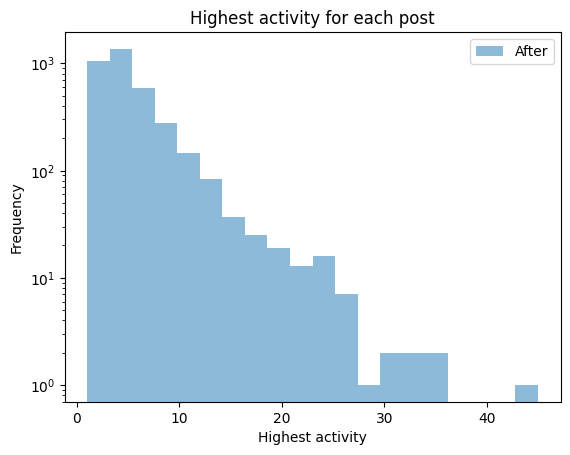

In [634]:
# plot max activity for each post
plt.hist(
    [post.highest_activity for post in sim.posts],
    label="After",
    alpha=0.5,
    bins=20,
)
# log y scale
plt.yscale("log")
plt.title("Highest activity for each post")
plt.xlabel("Highest activity")
plt.ylabel("Frequency")
plt.legend()
plt.show()